In [3]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

reviews_df = pd.read_csv('data/hotels/515K_Hotel_Reviews.csv')
reviews_df.head()

,review_date,hotel_name,review,is_bad_review,review_clean
0,8/3/2017,Hotel Arena,I am so angry that i made this post available...,1,angry make post available via possible site us...
1,8/3/2017,Hotel Arena,No real complaints the hotel was great great ...,0,real complaint hotel great great location surr...
2,7/31/2017,Hotel Arena,Rooms are nice but for elderly a bit difficul...,0,room nice elderly bit difficult room two story...
3,7/31/2017,Hotel Arena,My room was dirty and I was afraid to walk ba...,1,room dirty afraid walk barefoot floor look cle...
4,7/24/2017,Hotel Arena,You When I booked with your company on line y...,0,book company line show picture room think get ...


In [4]:
# 1.

# NLTK Preinstalling preparations
# import nltk
# nltk.download('vader_lexicon')


from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].progress_apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].progress_apply(pd.Series)], axis=1)

  0%|          | 0/515207 [00:00<?, ?it/s]

100%|██████████| 515207/515207 [02:06<00:00, 4078.71it/s]


In [5]:
# 2.

reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [6]:
# 3.


from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(
    reviews_df["review_clean"].progress_apply(lambda x: x.split(" "))
)]

model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

doc2vec_df = reviews_df["review_clean"].progress_apply(
    lambda x: model.infer_vector(x.split(" "))
).progress_apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

100%|██████████| 515207/515207 [06:35<00:00, 1304.25it/s]


In [7]:
# 4.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10, max_features=5000)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [8]:
reviews_df.head()

,review_date,hotel_name,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,...,word_young,word_youth,word_youtube,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zoo,word_zuid
0,8/3/2017,Hotel Arena,I am so angry that i made this post available...,1,angry make post available via possible site us...,0.083,0.859,0.058,-0.8589,1913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8/3/2017,Hotel Arena,No real complaints the hotel was great great ...,0,real complaint hotel great great location surr...,0.058,0.757,0.186,0.9494,611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7/31/2017,Hotel Arena,Rooms are nice but for elderly a bit difficul...,0,room nice elderly bit difficult room two story...,0.111,0.671,0.218,0.8402,301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7/31/2017,Hotel Arena,My room was dirty and I was afraid to walk ba...,1,room dirty afraid walk barefoot floor look cle...,0.099,0.754,0.147,0.9355,1221,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7/24/2017,Hotel Arena,You When I booked with your company on line y...,0,book company line show picture room think get ...,0.058,0.861,0.081,0.5263,774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
reviews_df.shape

(515207, 5016)

In [10]:
# 5.

reviews_df["is_bad_review"].value_counts(normalize = True)

is_bad_review
0    0.956827
1    0.043173
Name: proportion, dtype: float64

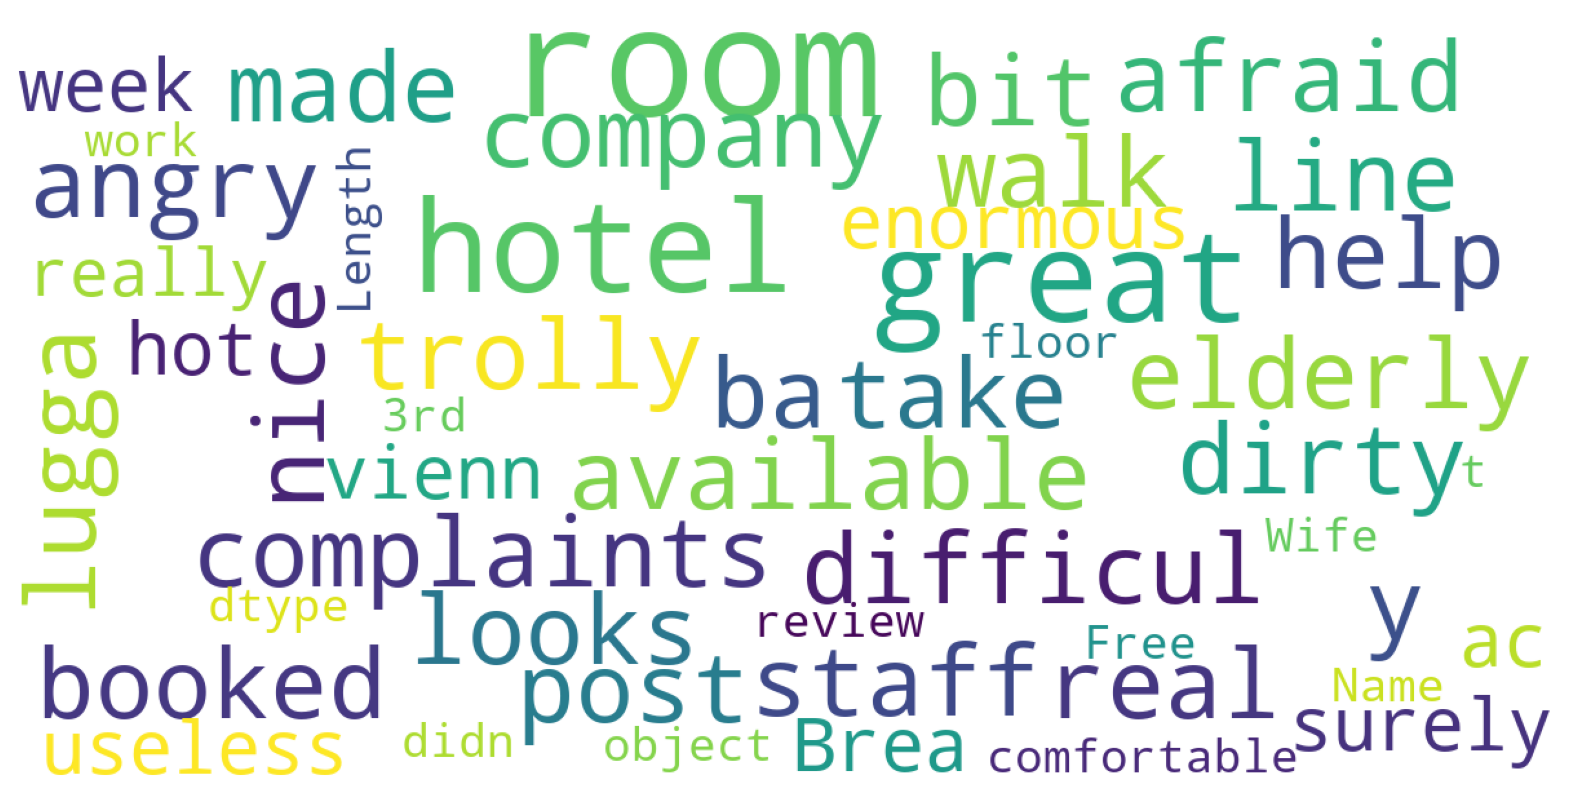

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(reviews_df["review"])

In [12]:
# 6.

reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
340384,Great great great o,1.000
296735,Clean comfortable efficient,1.000
317499,Great Nice,1.000
176463,Clean helpful efficient,1.000
180336,A super friendly welcome,1.000
335178,Nice clean comfortable,1.000
80326,Lovely clean comfortable warm,1.000
173812,clean comfortable attractive,1.000
49502,Great great great,1.000
50063,Friendly helpful staff Clean super comfortable,0.941


In [13]:
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
50321,no complaints no complaints,1.000
166366,No complaints No complaints,1.000
46199,n a No complaints,1.000
225026,Nothing perfect Great great great,0.928
324468,Nothing Clean Gorgeous Perfect,0.894
318893,Nothing Classy calm perfect,0.880
47824,Nothing Good good good,0.878
442432,Nothing Clean friendly efficient,0.878
453052,Dirty bad condition,0.865
67331,Abusive sarcastic m staff,0.861


C:\Users\butil\AppData\Local\Temp\ipykernel_14804\1217740470.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['compound'], hist = False, label=label)
C:\Users\butil\AppData\Local\Temp\ipykernel_14804\1217740470.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sub

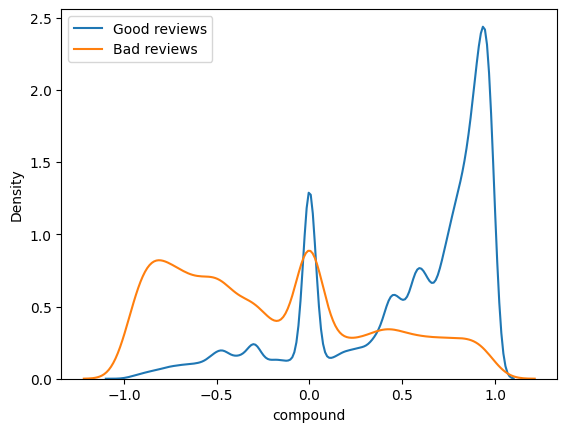

In [14]:
# 7.

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label=label)
    
plt.legend()
plt.show()

In [23]:
# 8.

import dateutil.parser
from sklearn.model_selection import train_test_split


def get_timestamp(dates):
    timestamps = [dateutil.parser.parse(d).timestamp() for d in dates]
    return timestamps

reviews_df['review_date'] = get_timestamp(reviews_df['review_date'])

label = "is_bad_review"
ignore_cols = [label, "hotel_name", "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]


subset_df = reviews_df.sample(frac=0.1, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(subset_df[features], subset_df[label], test_size=0.20, random_state=42)


In [24]:
# 9.

from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)


feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
4,compound,0.044821
3,pos,0.022999
1,neg,0.021371
7,doc2vec_vector_0,0.019383
11,doc2vec_vector_4,0.017697
10,doc2vec_vector_3,0.017379
8,doc2vec_vector_1,0.016343
5,nb_chars,0.015881
9,doc2vec_vector_2,0.015829
0,review_date,0.014969


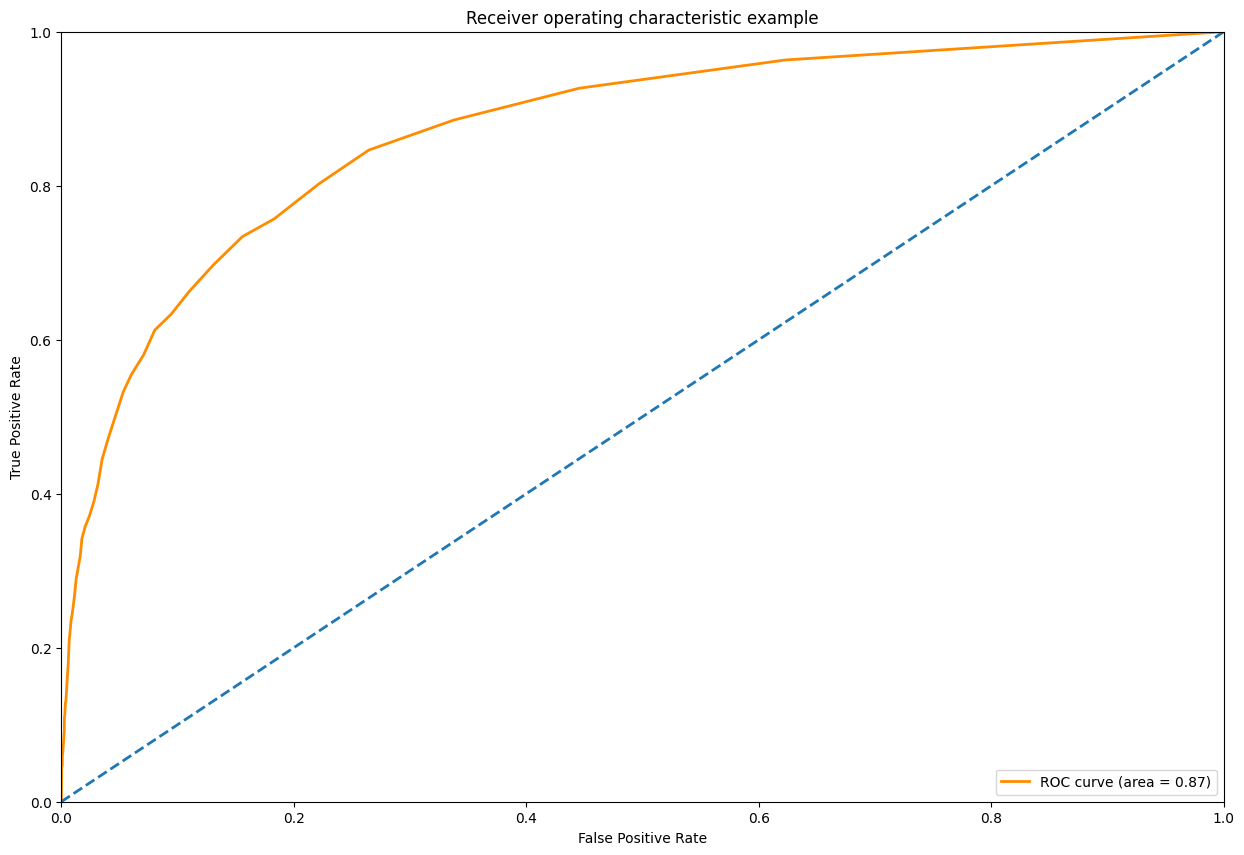

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.34')

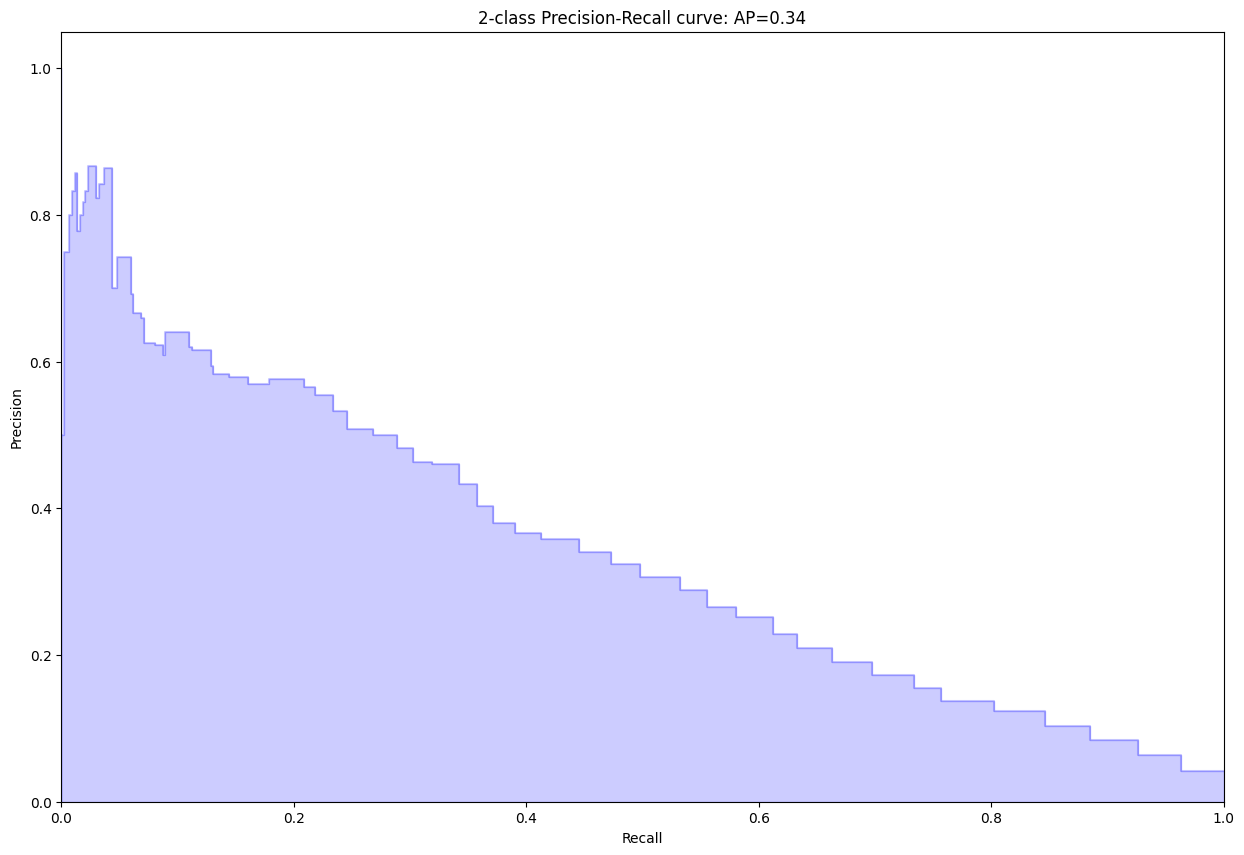

In [32]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from funcsigs import signature


average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))